In [1]:
library(lme4)
library(lmerTest)
library(emmeans)
library(repr)
library(glue)
library(performance)
library(IRdisplay)
library(comprehenr)
library(GLMMadaptive)
library(multilevelTools)
library(data.table)
library(dplyr)
library(ggplot2)
library(ordinal)
library(tibble)
library(tidyr)
library(data.table)
library(xtable)
library(RVAideMemoire)
library(jtools)


Loading required package: Matrix


Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Warning message:
"package 'glue' was built under R version 4.3.3"

Attaching package: 'IRdisplay'


The following object is masked from 'package:performance':

    display



Attaching package: 'GLMMadaptive'


The following object is masked from 'package:lme4':

    negative.binomial



Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'ordinal'


The following object is masked from 'package:dplyr':

    slice



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack



Attaching pack

In [2]:
options(width = 160, repr.plot.width = 20, repr.plot.height = 8)

In [3]:
current_participants_df <- read.csv('./human_evals_data/current_participants_df.csv')

# Set columns as categorical
current_participants_df$participant_id <- as.factor(current_participants_df$participant_id)
current_participants_df$game_id <- as.factor(current_participants_df$game_id)
current_participants_df$game_type <- as.factor(current_participants_df$game_type)
current_participants_df$full_game_id <- as.factor(current_participants_df$full_game_id)

# Change the order of game_type levels
current_participants_df$game_type <- factor(current_participants_df$game_type, levels = c('unmatched', 'unmatched_top_30', 'matched', 'real'))


# Set columns as booleans
current_participants_df$real <- as.logical(current_participants_df$real)
current_participants_df$matched <- as.logical(current_participants_df$matched)
current_participants_df$model_game <- (!current_participants_df$real)

ATTRIBUTES <- c("confident", "fun_play", "fun_watch", "capability", "goldilocks", "creativity", "human_likeness")
NORMALIZED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("normalized_{attr}") } )
CENTERED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("centered_{attr}") } )
FULL_NORMALIZED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("full_normalized_{attr}") })

for (i in seq_along(CENTERED_ATTRIBUTES)) {
    current_participants_df[[CENTERED_ATTRIBUTES[i]]] <- current_participants_df[[ATTRIBUTES[i]]] - 3
}

for (i in seq_along(FULL_NORMALIZED_ATTRIBUTES)) {
    current_participants_df[[FULL_NORMALIZED_ATTRIBUTES[i]]] <- (current_participants_df[[ATTRIBUTES[i]]] - mean(current_participants_df[[ATTRIBUTES[i]]])) / sd(current_participants_df[[ATTRIBUTES[i]]])
}



print(dim(current_participants_df))
head(current_participants_df, 2)

[1] 1292   50


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,...,centered_goldilocks,centered_creativity,centered_human_likeness,full_normalized_confident,full_normalized_fun_play,full_normalized_fun_watch,full_normalized_capability,full_normalized_goldilocks,full_normalized_creativity,full_normalized_human_likeness
,<fct>,<fct>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",FALSE,FALSE,4,3,3,5,3,2,...,0,-1,-1,0.3349299,0.685856,0.736462,1.7028050,0.3154651,-0.1941839,-0.3231405
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",FALSE,FALSE,4,3,3,4,3,3,...,0,0,-1,0.3349299,0.685856,0.736462,0.8894874,0.3154651,0.7489952,-0.3231405


In [4]:
filtered_df <- current_participants_df[current_participants_df$game_type != 'unmatched', ]
filtered_df$game_type <- droplevels(filtered_df$game_type)

print(dim(filtered_df))
head(filtered_df, 2)

[1] 892  50


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,...,centered_goldilocks,centered_creativity,centered_human_likeness,full_normalized_confident,full_normalized_fun_play,full_normalized_fun_watch,full_normalized_capability,full_normalized_goldilocks,full_normalized_creativity,full_normalized_human_likeness
,<fct>,<fct>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",TRUE,TRUE,4,2,2,5,4,3,...,1,0,-1,0.3349299,-0.2092207,-0.1445648,1.70280498,1.2524326,0.7489952,-0.3231405
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",FALSE,TRUE,5,4,4,3,2,2,...,-1,-1,-1,1.1049113,1.5809328,1.6174888,0.07616983,-0.6215025,-0.1941839,-0.3231405


## Do we need a random effect for participants?

In [13]:
# Iterate through attributes
for (attr in ATTRIBUTES) {
    attr.mm_no_participant_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )
    attr.mm_with_participant_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | full_game_id) + (1 | participant_id)")),
        data = filtered_df, Hess = TRUE
    )

    anova_results <- anova(attr.mm_no_participant_id, attr.mm_with_participant_id)
    attr.aic_before <- anova_results$AIC[[1]]
    attr.aic_after <- anova_results$AIC[[2]]
    attr.aic_diff <- attr.aic_before - attr.aic_after
    attr.chisq <- anova_results$Chisq[[2]]
    attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 
    
    print(glue("For {attr}, adding the participant ID random effects results in AIC diff: {format(attr.aic_diff, nsmall=3)} | Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))
}



For confident, adding the participant ID random effects results in AIC diff: 98.78088 | Chi-squared: NULL | p-value: 1.027435e-23
For fun_play, adding the participant ID random effects results in AIC diff: 248.459 | Chi-squared: NULL | p-value: 2.062364e-56
For fun_watch, adding the participant ID random effects results in AIC diff: 381.5017 | Chi-squared: NULL | p-value: 2.150804e-85
For capability, adding the participant ID random effects results in AIC diff: 350.6805 | Chi-squared: NULL | p-value: 1.10518e-78
For goldilocks, adding the participant ID random effects results in AIC diff: 89.72851 | Chi-squared: NULL | p-value: 9.942224e-22
For creativity, adding the participant ID random effects results in AIC diff: 257.707 | Chi-squared: NULL | p-value: 1.987821e-58
For human_likeness, adding the participant ID random effects results in AIC diff: 182.0796 | Chi-squared: NULL | p-value: 6.233415e-42


Absolutely we do.

## Do we need a random effect for games?

In [10]:


# Iterate through attributes
for (attr in ATTRIBUTES) {
    attr.mm_no_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id)")),
        data = filtered_df, Hess = TRUE
    )
    attr.mm_with_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )

    anova_results <- anova(attr.mm_no_game_id, attr.mm_with_game_id)
    attr.aic_before <- anova_results$AIC[[1]]
    attr.aic_after <- anova_results$AIC[[2]]
    attr.aic_diff <- attr.aic_before - attr.aic_after
    attr.chisq <- anova_results$Chisq[[2]]
    attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 
    
    print(glue("For {attr}, adding the game ID random effects results in AIC diff: {format(attr.aic_diff, nsmall=3)} | Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))
}



For confident, adding the game ID random effects results in AIC diff: 49.03556 | Chi-squared: NULL | p-value: 9.070776e-13
For fun_play, adding the game ID random effects results in AIC diff: 39.63944 | Chi-squared: NULL | p-value: 1.097565e-10
For fun_watch, adding the game ID random effects results in AIC diff: 26.17496 | Chi-squared: NULL | p-value: 1.108294e-07
For capability, adding the game ID random effects results in AIC diff: -1.977122 | Chi-squared: NULL | p-value: 0.8797742
For goldilocks, adding the game ID random effects results in AIC diff: 108.3868 | Chi-squared: NULL | p-value: 8.062017e-26
For creativity, adding the game ID random effects results in AIC diff: 53.75391 | Chi-squared: NULL | p-value: 8.213478e-14
For human_likeness, adding the game ID random effects results in AIC diff: 29.1491 | Chi-squared: NULL | p-value: 2.389503e-08


Sure seems to help in almost every attribute.

## Given the two random effects, do we need both fixed effects?


In [11]:

# Iterate through attributes
for (attr in ATTRIBUTES) {
    attr.mm_no_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + (1 | participant_id)+ (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )
    attr.mm_with_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )

    anova_results <- anova(attr.mm_no_game_id, attr.mm_with_game_id)
    attr.aic_before <- anova_results$AIC[[1]]
    attr.aic_after <- anova_results$AIC[[2]]
    attr.aic_diff <- attr.aic_before - attr.aic_after
    attr.chisq <- anova_results$Chisq[[2]]
    attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 

    display_text(glue("For {attr}, adding the fitness fixed effect results in AIC diff: {format(attr.aic_diff, nsmall=3)} | Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))
}


For confident, adding the fitness fixed effect results in AIC diff: 27.00703 | Chi-squared: NULL | p-value: 7.211615e-08

For fun_play, adding the fitness fixed effect results in AIC diff: 6.39548 | Chi-squared: NULL | p-value: 0.003761551

For fun_watch, adding the fitness fixed effect results in AIC diff: 0.1528605 | Chi-squared: NULL | p-value: 0.1423045

For capability, adding the fitness fixed effect results in AIC diff: 2.6284 | Chi-squared: NULL | p-value: 0.03144689

For goldilocks, adding the fitness fixed effect results in AIC diff: 9.235787 | Chi-squared: NULL | p-value: 0.0008023506

For creativity, adding the fitness fixed effect results in AIC diff: 7.793806 | Chi-squared: NULL | p-value: 0.001751007

For human_likeness, adding the fitness fixed effect results in AIC diff: 15.69761 | Chi-squared: NULL | p-value: 2.589511e-05

In [12]:
# Iterate through attributes
for (attr in ATTRIBUTES) {
    attr.mm_no_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + normalized_fitness + (1 | participant_id)+ (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )
    attr.mm_with_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )

    anova_results <- anova(attr.mm_no_game_id, attr.mm_with_game_id)
    attr.aic_before <- anova_results$AIC[[1]]
    attr.aic_after <- anova_results$AIC[[2]]
    attr.aic_diff <- attr.aic_before - attr.aic_after
    attr.chisq <- anova_results$Chisq[[2]]
    attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 
    
    display_text(glue("For {attr}, adding the game type fixed effect results in AIC diff: {format(attr.aic_diff, nsmall=3)} | Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))
}



For confident, adding the game type fixed effect results in AIC diff: 10.92737 | Chi-squared: NULL | p-value: 0.0005735382

For fun_play, adding the game type fixed effect results in AIC diff: 11.43894 | Chi-squared: NULL | p-value: 0.0004440957

For fun_watch, adding the game type fixed effect results in AIC diff: 8.654934 | Chi-squared: NULL | p-value: 0.001786554

For capability, adding the game type fixed effect results in AIC diff: 0.4869532 | Chi-squared: NULL | p-value: 0.106089

For goldilocks, adding the game type fixed effect results in AIC diff: -1.05349 | Chi-squared: NULL | p-value: 0.2291783

For creativity, adding the game type fixed effect results in AIC diff: -0.4096395 | Chi-squared: NULL | p-value: 0.1660975

For human_likeness, adding the game type fixed effect results in AIC diff: 23.48259 | Chi-squared: NULL | p-value: 1.077041e-06


## Fit and analyze the full mixed effects model

In [5]:
analysis_df <- data.table::copy(filtered_df)
model_list <- list()
marginal_mean_list <- list()

for (attr in ATTRIBUTES) {
    display_markdown(glue("## {attr}"))

    # Create formula with current attribute
    attr.mm <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1  + normalized_fitness + C(game_type) + (1 | participant_id) + (1 | full_game_id)")),
        data = analysis_df, Hess = TRUE
    )

    model_list[[attr]] <- attr.mm

    display_markdown("### Mixed Effects Model")    
    s <- capture.output(
        print(summary(attr.mm))
    )
    display_text(s)

    attr.marginal_means = emmeans(attr.mm, "game_type")
    marginal_mean_list[[attr]] <- attr.marginal_means
    display_markdown("### Marginal Means")
    s <- capture.output(
        print(pairs(attr.marginal_means, reverse = TRUE))
    )
    display_text(s)

    display_markdown("------------------")
}


## confident

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(confident) ~ 1 + normalized_fitness + C(game_type) + (1 | participant_id) +      (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1182.29 2382.59 755(3012) 2.29e-04 8.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.2831   1.1327  
 full_game_id   (Intercept) 0.7669   0.8757  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness    0.8459     0.1504   5.625 1.86e-08 ***
C(game_type)matched   0.5253     0.2974   1.766   0.0773 .  
C(game_type)real      1.1511     0.2852   4.036 5.43e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2 -2.80972    0.26835 -10.471
2|3 -1.36745    0.24135  -5.666
3|4 -0.01

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.525 0.297 Inf   1.766  0.1810
 real - unmatched_top_30       1.151 0.285 Inf   4.036  0.0002
 real - matched                0.626 0.305 Inf   2.055  0.0995

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## fun_play

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(fun_play) ~ 1 + normalized_fitness + C(game_type) + (1 | participant_id) +      (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1134.46 2286.92 699(4357) 3.32e-04 6.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.8697   1.6940  
 full_game_id   (Intercept) 0.5779   0.7602  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness    0.3956     0.1347   2.936  0.00332 ** 
C(game_type)matched   0.6287     0.2736   2.298  0.02158 *  
C(game_type)real      1.0589     0.2633   4.021  5.8e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.9559     0.2597  -3.681
2|3   1.1138     0.2624   4.245
3|4   3.29

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.629 0.274 Inf   2.298  0.0561
 real - unmatched_top_30       1.059 0.263 Inf   4.021  0.0002
 real - matched                0.430 0.273 Inf   1.577  0.2556

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## fun_watch

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(fun_watch) ~ 1 + normalized_fitness + C(game_type) + (1 | participant_id) +      (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1077.05 2172.09 642(4301) 3.19e-04 6.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 4.4133   2.1008  
 full_game_id   (Intercept) 0.5064   0.7116  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness    0.1912     0.1302   1.469  0.14196    
C(game_type)matched   0.6413     0.2657   2.414  0.01577 *  
C(game_type)real      0.9118     0.2571   3.547  0.00039 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.7974     0.2862  -2.786
2|3   1.4145     0.2925   4.836
3|4   3.5

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.641 0.266 Inf   2.414  0.0417
 real - unmatched_top_30       0.912 0.257 Inf   3.547  0.0011
 real - matched                0.271 0.264 Inf   1.025  0.5608

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## capability

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(capability) ~ 1 + normalized_fitness + C(game_type) + (1 |      participant_id) + (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1191.32 2400.65 688(4093) 1.16e-03 4.9e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 3.616428 1.90169 
 full_game_id   (Intercept) 0.007948 0.08915 
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)  
normalized_fitness  -0.18855    0.08718  -2.163   0.0306 *
C(game_type)matched  0.34903    0.17045   2.048   0.0406 *
C(game_type)real     0.23183    0.16090   1.441   0.1496  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.9044     0.2543 -11.421
2|3  -0.6740     0.2313  -2.914
3|4   1.1571    

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.349 0.170 Inf   2.048  0.1010
 real - unmatched_top_30       0.232 0.161 Inf   1.441  0.3199
 real - matched               -0.117 0.167 Inf  -0.701  0.7630

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## goldilocks

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(goldilocks) ~ 1 + normalized_fitness + C(game_type) + (1 |      participant_id) + (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1106.95 2231.91 570(2858) 1.15e-03 8.2e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.161    1.078   
 full_game_id   (Intercept) 1.256    1.121   
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness   -0.5878     0.1707  -3.443 0.000576 ***
C(game_type)matched   0.3630     0.3529   1.029 0.303615    
C(game_type)real     -0.2498     0.3377  -0.740 0.459502    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.3600     0.2832  -8.335
2|3  -0.7327     0.2700  -2.713
3|4   2.

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.363 0.353 Inf   1.029  0.5587
 real - unmatched_top_30      -0.250 0.338 Inf  -0.740  0.7399
 real - matched               -0.613 0.355 Inf  -1.725  0.1957

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## creativity

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(creativity) ~ 1 + normalized_fitness + C(game_type) + (1 |      participant_id) + (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1076.82 2171.64 648(3603) 5.40e-04 7.1e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.9318   1.7122  
 full_game_id   (Intercept) 0.8534   0.9238  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)   
normalized_fitness   -0.4863     0.1524  -3.191  0.00142 **
C(game_type)matched   0.5507     0.3101   1.776  0.07580 . 
C(game_type)real      0.4377     0.2983   1.467  0.14226   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -1.2302     0.2820  -4.363
2|3   1.0634     0.2822   3.769
3|4   3.3883

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.551 0.310 Inf   1.776  0.1778
 real - unmatched_top_30       0.438 0.298 Inf   1.467  0.3067
 real - matched               -0.113 0.310 Inf  -0.364  0.9296

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## human_likeness

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(human_likeness) ~ 1 + normalized_fitness + C(game_type) + (1 |      participant_id) + (1 | full_game_id)
data:    analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1215.28 2448.56 661(3291) 1.89e-03 7.5e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.951    1.3967  
 full_game_id   (Intercept) 0.544    0.7375  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
normalized_fitness    0.5698     0.1320   4.316 1.59e-05 ***
C(game_type)matched   0.8368     0.2676   3.128  0.00176 ** 
C(game_type)real      1.4455     0.2583   5.597 2.18e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.8014     0.2376  -3.373
2|3   0.9950     0.2399   4.148
3|4 

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.837 0.268 Inf   3.128  0.0050
 real - unmatched_top_30       1.446 0.258 Inf   5.597  <.0001
 real - matched                0.609 0.265 Inf   2.299  0.0559

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

# Generate some model summary figures 
Added to extended data in the final submission

First, a coefficient comparison for the full model (Figure ED-7)

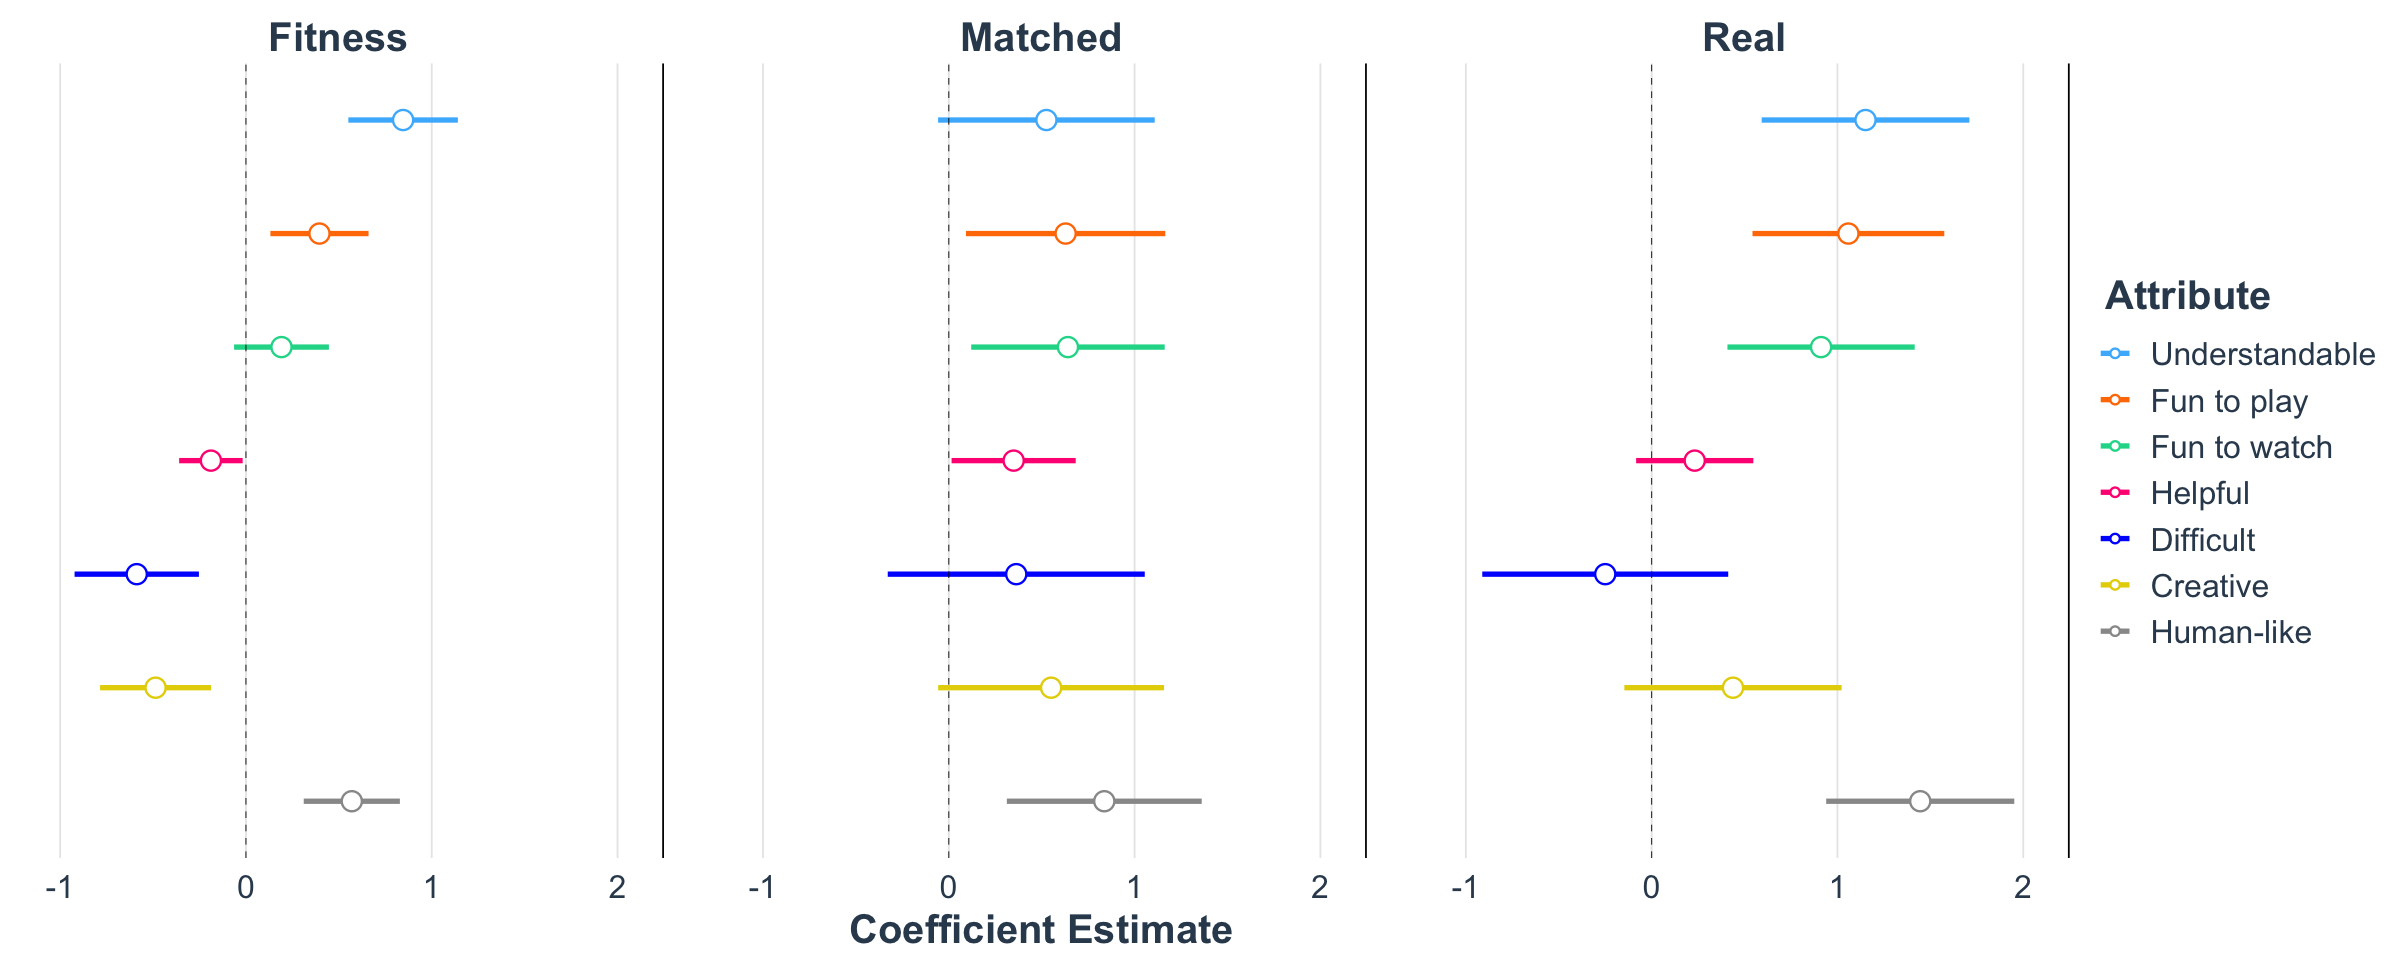

In [9]:
ATTRIBUTES_NAMES <- c("Understandable", "Fun to play", "Fun to watch", "Helpful", "Difficult", "Creative", "Human-like")

groups <- list(Fitness = c("Fitness"), Real = c("Real"), Matched = c("Matched"))

plot_summs(
    model_list,
    model.names = ATTRIBUTES_NAMES,
    coefs = c("Fitness" = "normalized_fitness", "Real" = "C(game_type)real", "Matched" = "C(game_type)matched"),
    groups = groups,
    facet.rows = 1, facet.cols = 3,
    point.size = 10,
    point.shape = FALSE,
    line.size = c(1.5, 3),
    legend.title = "Attribute",
    scale = TRUE, robust = TRUE
) + theme(
    text = element_text(size = 24),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank(),
    panel.spacing = unit(2, "lines"),
    # strip.text = element_text(label = as.expression("test")),
) +
    annotate(
        geom = "segment",
        x = Inf, xend = Inf,
        y = -Inf, yend = Inf,
        color = "black", , size = 1
    ) + coord_cartesian(ylim = c(0.75, 1.25), xlim = c(-1.25, 2.25), expand = FALSE) +
    xlab("Coefficient Estimate")

ggsave('./figures/full_model_coefficient_comparison.pdf', dpi=900, width=20, height=6)

Summarize the `emmeans` pairwise comparisons for the full model

In [10]:
summary_list <- list()

CONTRAST_NAMES <- c("Matched - Unmatched", "Real - Unmatched", "Real - Matched")
for (i in seq_along(marginal_mean_list)) {
    attr <- names(marginal_mean_list)[i]
    p <- pairs(marginal_mean_list[[attr]], reverse = TRUE)
    s <- summary(p)
    s$contrast <- CONTRAST_NAMES
    s$attribute <- ATTRIBUTES_NAMES[i]
    summary_list[[i]] <- s
}

combined_summary_df <- do.call(rbind, summary_list)
combined_summary_df$contrast <- factor(combined_summary_df$contrast, levels = rev(CONTRAST_NAMES), ordered = TRUE)
combined_summary_df$attribute <- factor(combined_summary_df$attribute, levels = ATTRIBUTES_NAMES, ordered = TRUE)
combined_summary_df$SE2 = combined_summary_df$SE * 2
head(combined_summary_df)

,contrast,estimate,SE,df,z.ratio,p.value,attribute,SE2
,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>
1,Matched - Unmatched,0.5253317,0.2974160,Inf,1.766320,0.1810123898,Understandable,0.5948321
2,Real - Unmatched,1.1511036,0.2851898,Inf,4.036272,0.0001605517,Understandable,0.5703796
3,Real - Matched,0.6257718,0.3045627,Inf,2.054657,0.0994748132,Understandable,0.6091253
4,Matched - Unmatched,0.6287354,0.2736421,Inf,2.297656,0.0561173428,Fun to play,0.5472842
5,Real - Unmatched,1.0588619,0.2633379,Inf,4.020924,0.0001713201,Fun to play,0.5266758
6,Real - Matched,0.4301265,0.2727404,Inf,1.577054,0.2555775809,Fun to play,0.5454809


Plot these comparisons (Figure SI-5)

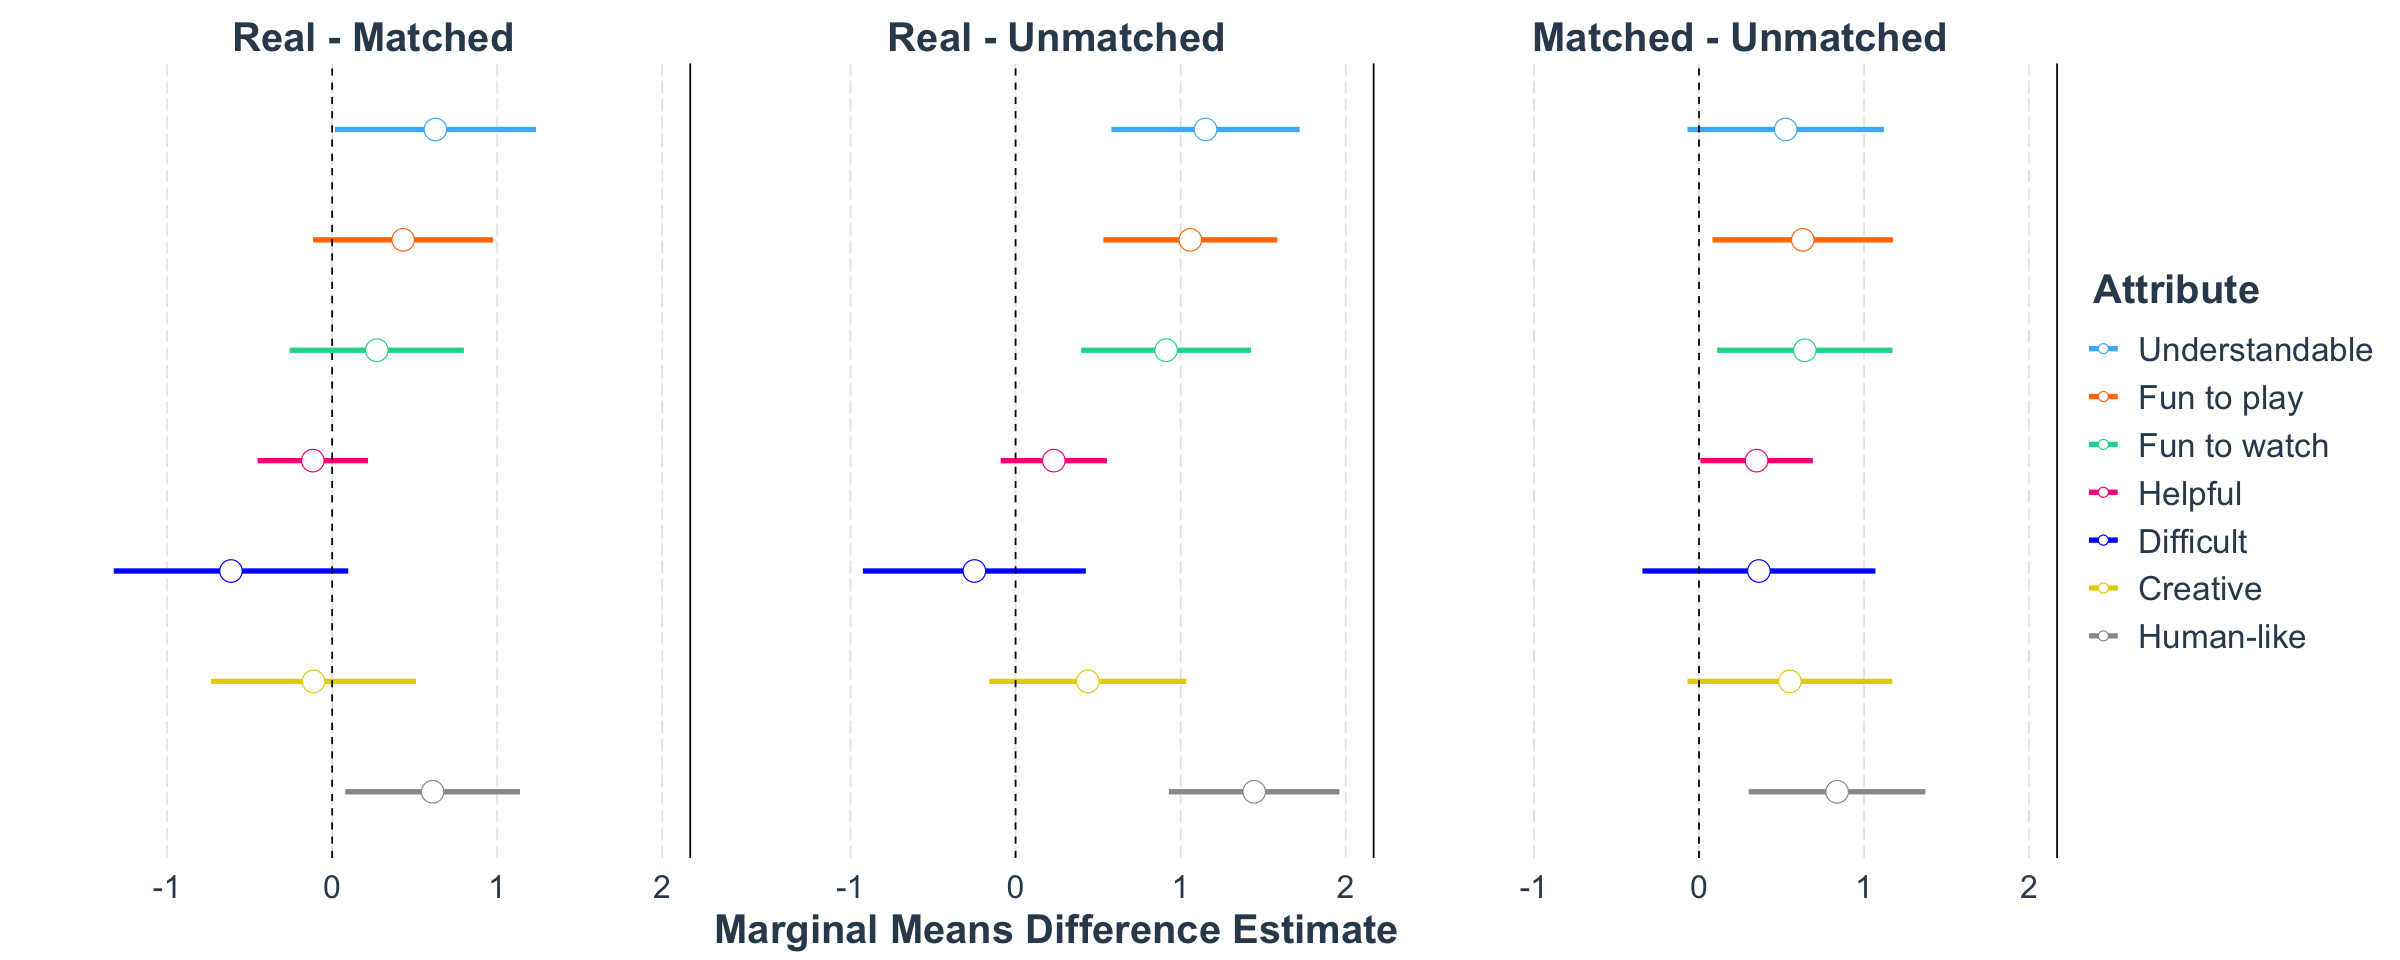

In [12]:
ggplot(combined_summary_df, aes(x = estimate, y = attribute, color = contrast)) +
    geom_errorbarh(aes(xmin = estimate - SE2, xmax = estimate + SE2), height = 0, size = 1.5) +
    geom_point(size = 6, shape = 21, fill = "white") +
    aes(color = attribute) +
    scale_y_discrete(limits = rev) +
    scale_color_manual(values = get_colors(as.list("CUD Bright"), 7)) +
    facet_wrap(~contrast, nrow = 1, ncol = 3) +
    # scale_color_jtools(palette = "cud_bright") +
    labs(x = "Estimate", y = "Attribute") +
    theme_nice() +
    theme(
        text = element_text(size = 24, face = "bold"),
        legend.position = "right",
        legend.text = element_text(size = 20, face = "plain"),
        # legend.key.spacing.y = unit(0.4, "cm"),
        # legend.key.size = unit(1, "cm"),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(face = "plain"),
        strip.text = element_text(size = 24, face = "bold"),
    ) +
    guides(color = guide_legend(title = "Attribute", override.aes = list(linetype = "solid", shape = 21, size = 2.5, linewidth = 1.5), byrow = TRUE)) +
    annotate(
        geom = "segment",
        x = Inf, xend = Inf,
        y = -Inf, yend = Inf,
        color = "black", , size = 1
    ) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
    xlim(-1.5, 2) +
    xlab("Marginal Means Difference Estimate") +
    ylab("") +
    theme(legend.spacing.y = unit(0.5, "cm"))

ggsave('./figures/full_model_marginal_means.pdf', dpi=900, width=20, height=6)


# Mixed Effect Model Summary Table
This code generates Table SI-3, from which Table ED-2 is derived.

In [17]:
truncate_p_values <- FALSE
sig_figs <- 3

results_table <- data.frame(
    attribute = character(), 
    aic = numeric(),
    fit_est = numeric(),
    fit_z = numeric(),
    fit_p = numeric(),
    matched_est = numeric(),
    matched_z = numeric(),
    matched_p = numeric(),
    real_est = numeric(),
    real_z = numeric(),
    real_p = numeric()
)


for (name in names(model_list)) {
    model <- model_list[[name]]
    s <- summary(model)
    table_row <- data.frame(
        attribute = name,
        fit_est = glue("${formatC(s$coefficients[5, 1], digits = sig_figs, format = 'f')} \\pm {formatC(s$coefficients[5, 2], digits = sig_figs, format = 'f')}$"),  # s$coefficients[5, 1],
        fit_z = formatC(s$coefficients[5, 3], digits = sig_figs, format = 'f'),
        fit_p = s$coefficients[5, 4],
        matched_est = glue("${formatC(s$coefficients[6, 1], digits = sig_figs, format = 'f')} \\pm {formatC(s$coefficients[6, 2], digits = sig_figs, format = 'f')}$"),
        matched_z = formatC(s$coefficients[6, 3], digits = sig_figs, format = 'f'),
        matched_p = s$coefficients[6, 4],
        real_est = glue("${formatC(s$coefficients[7, 1], digits = sig_figs, format = 'f')} \\pm {formatC(s$coefficients[7, 2], digits = sig_figs, format = 'f')}$"),
        real_z = formatC(s$coefficients[7, 3], digits = sig_figs, format = 'f'),
        real_p = s$coefficients[7, 4]
    )
    results_table <- rbind(results_table, table_row)
}



# Iterate through the columns
for (col in c("fit_p", "matched_p", "real_p")) {
    # Iterate through the cells
    for (i in seq_len(nrow(results_table))) {
        # Get the current value
        value <- as.double(results_table[i, col])
        # Modify the value based on the conditions
        if (truncate_p_values && value < 10^-5) {
            results_table[i, col] <- "$P < \\num{1e-5}^{ *** }$"
        } else if (truncate_p_values && value < 10^-3) {
            results_table[i, col] <- "$P < \\num{1e-3}^{ *** }$"
        } else {
            use_scientific <- value < 0.01
            v <- formatC(value, digits = sig_figs, format = ifelse(use_scientific, "e", "f"))
            if (use_scientific) {
                v <- glue("\\num{{{v}}}")
            }
            stars <- ifelse(value < 0.001, "***",
                ifelse(value < 0.01, "**", ifelse(value < 0.05, "*", ""))
            )
            if (stars != "") {
                results_table[i, col] <- glue("$P = {v}^{{ {stars} }}$")
            } else {
                results_table[i, col] <- glue("$P = {v}$")
            }
        }
    }
}


results_table

attribute,fit_est,fit_z,fit_p,matched_est,matched_z,matched_p,real_est,real_z,real_p
<chr>,<glue>,<chr>,<chr>,<glue>,<chr>,<chr>,<glue>,<chr>,<chr>
confident,$0.846 \pm 0.150$,5.625,$P = \num{1.858e-08}^{ *** }$,$0.525 \pm 0.297$,1.766,$P = 0.077$,$1.151 \pm 0.285$,4.036,$P = \num{5.431e-05}^{ *** }$
fun_play,$0.396 \pm 0.135$,2.936,$P = \num{3.322e-03}^{ ** }$,$0.629 \pm 0.274$,2.298,$P = 0.022^{ * }$,$1.059 \pm 0.263$,4.021,$P = \num{5.797e-05}^{ *** }$
fun_watch,$0.191 \pm 0.130$,1.469,$P = 0.142$,$0.641 \pm 0.266$,2.414,$P = 0.016^{ * }$,$0.912 \pm 0.257$,3.547,$P = \num{3.901e-04}^{ *** }$
capability,$-0.189 \pm 0.087$,-2.163,$P = 0.031^{ * }$,$0.349 \pm 0.170$,2.048,$P = 0.041^{ * }$,$0.232 \pm 0.161$,1.441,$P = 0.150$
goldilocks,$-0.588 \pm 0.171$,-3.443,$P = \num{5.763e-04}^{ *** }$,$0.363 \pm 0.353$,1.029,$P = 0.304$,$-0.250 \pm 0.338$,-0.740,$P = 0.460$
creativity,$-0.486 \pm 0.152$,-3.191,$P = \num{1.416e-03}^{ ** }$,$0.551 \pm 0.310$,1.776,$P = 0.076$,$0.438 \pm 0.298$,1.467,$P = 0.142$
human_likeness,$0.570 \pm 0.132$,4.316,$P = \num{1.589e-05}^{ *** }$,$0.837 \pm 0.268$,3.128,$P = \num{1.762e-03}^{ ** }$,$1.446 \pm 0.258$,5.597,$P = \num{2.179e-08}^{ *** }$


In [18]:
# Convert the dataframe to an xtable object
table_latex <- xtable(results_table, digits = 3)

# Print the LaTeX table
print(table_latex, include.rownames = FALSE, floating = FALSE, sanitize.text.function = identity, digits=3)


% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Wed May 29 14:22:27 2024
\begin{tabular}{llllllllll}
  \hline
attribute & fit_est & fit_z & fit_p & matched_est & matched_z & matched_p & real_est & real_z & real_p \\ 
  \hline
confident & $0.846 \pm 0.150$ & 5.625 & $P = \num{1.858e-08}^{ *** }$ & $0.525 \pm 0.297$ & 1.766 & $P = 0.077$ & $1.151 \pm 0.285$ & 4.036 & $P = \num{5.431e-05}^{ *** }$ \\ 
  fun_play & $0.396 \pm 0.135$ & 2.936 & $P = \num{3.322e-03}^{ ** }$ & $0.629 \pm 0.274$ & 2.298 & $P = 0.022^{ * }$ & $1.059 \pm 0.263$ & 4.021 & $P = \num{5.797e-05}^{ *** }$ \\ 
  fun_watch & $0.191 \pm 0.130$ & 1.469 & $P = 0.142$ & $0.641 \pm 0.266$ & 2.414 & $P = 0.016^{ * }$ & $0.912 \pm 0.257$ & 3.547 & $P = \num{3.901e-04}^{ *** }$ \\ 
  capability & $-0.189 \pm 0.087$ & -2.163 & $P = 0.031^{ * }$ & $0.349 \pm 0.170$ & 2.048 & $P = 0.041^{ * }$ & $0.232 \pm 0.161$ & 1.441 & $P = 0.150$ \\ 
  goldilocks & $-0.588 \pm 0.171$ & -3.443 & $P = \num{5.763e-04}^{ *** }$ & $0.

# Marginal Means Table
This code generates Table SI-4, from which Table 1 is derived

In [20]:
truncate_p_values <- FALSE
sig_figs <- 3

mm_results_table <- data.frame(
    attribute = character(),
    r_m_est = numeric(),
    r_m_z = numeric(),
    r_m_p = numeric(),
    r_u_est = numeric(),
    r_u_z = numeric(),
    r_u_p = numeric(),
    m_u_est = numeric(),
    m_u_z = numeric(),
    m_u_p = numeric()
    
)


for (name in names(model_list)) {
    model <- model_list[[name]]
    em <- emmeans(model, "game_type")
    p <- pairs(em, reverse = TRUE)
    s <- summary(p)
    table_row <- data.frame(
        attribute = name,
        r_m_est = glue("${formatC(s[3, 2], digits = sig_figs, format = 'f')} \\pm {formatC(s[3, 3], digits = sig_figs, format = 'f')}$"),
        r_m_z = formatC(s[3, 5], digits = sig_figs, format = "f"),
        r_m_p = s[3, 6],
        r_u_est = glue("${formatC(s[2, 2], digits = sig_figs, format = 'f')} \\pm {formatC(s[2, 3], digits = sig_figs, format = 'f')}$"),
        r_u_z = formatC(s[2, 5], digits = sig_figs, format = "f"),
        r_u_p = s[2, 6],
        m_u_est = glue("${formatC(s[1, 2], digits = sig_figs, format = 'f')} \\pm {formatC(s[1, 3], digits = sig_figs, format = 'f')}$"),
        m_u_z = formatC(s[1, 5], digits = sig_figs, format = "f"),
        m_u_p = s[1, 6]
    )
    mm_results_table <- rbind(mm_results_table, table_row)
}


# Iterate through the columns
for (col in c("m_u_p", "r_u_p", "r_m_p")) {
    # Iterate through the cells
    for (i in seq_len(nrow(mm_results_table))) {
        # Get the current value
        value <- as.double(mm_results_table[i, col])

        # Modify the value based on the conditions
        if (truncate_p_values && value < 10^-5) {
            mm_results_table[i, col] <- "$P < \\num{1e-5}^{ *** }$"
        } else if (truncate_p_values && value < 10^-3) {
            mm_results_table[i, col] <- "$P < \\num{1e-3}^{ *** }$"
        } else {
            use_scientific <- value < 0.01
            v <- formatC(value, digits = sig_figs, format = ifelse(use_scientific, "e", "f"))
            if (use_scientific) {
                v <- glue("\\num{{{v}}}")
            }
            stars <- ifelse(value < 0.001, "***",
                ifelse(value < 0.01, "**", ifelse(value < 0.05, "*", ""))
            )
            if (stars != "") {
                mm_results_table[i, col] <- glue("$P = {v}^{{ {stars} }}$")
            } else {
                mm_results_table[i, col] <- glue("$P = {v}$")
            }
        }
    }
}

mm_results_table

Warning message:
"contrasts dropped from factor C(game_type)"


Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"


attribute,r_m_est,r_m_z,r_m_p,r_u_est,r_u_z,r_u_p,m_u_est,m_u_z,m_u_p
<chr>,<glue>,<chr>,<chr>,<glue>,<chr>,<chr>,<glue>,<chr>,<chr>
confident,$0.626 \pm 0.305$,2.055,$P = 0.099$,$1.151 \pm 0.285$,4.036,$P = \num{1.606e-04}^{ *** }$,$0.525 \pm 0.297$,1.766,$P = 0.181$
fun_play,$0.430 \pm 0.273$,1.577,$P = 0.256$,$1.059 \pm 0.263$,4.021,$P = \num{1.713e-04}^{ *** }$,$0.629 \pm 0.274$,2.298,$P = 0.056$
fun_watch,$0.271 \pm 0.264$,1.025,$P = 0.561$,$0.912 \pm 0.257$,3.547,$P = \num{1.135e-03}^{ ** }$,$0.641 \pm 0.266$,2.414,$P = 0.042^{ * }$
capability,$-0.117 \pm 0.167$,-0.701,$P = 0.763$,$0.232 \pm 0.161$,1.441,$P = 0.320$,$0.349 \pm 0.170$,2.048,$P = 0.101$
goldilocks,$-0.613 \pm 0.355$,-1.725,$P = 0.196$,$-0.250 \pm 0.338$,-0.740,$P = 0.740$,$0.363 \pm 0.353$,1.029,$P = 0.559$
creativity,$-0.113 \pm 0.310$,-0.364,$P = 0.930$,$0.438 \pm 0.298$,1.467,$P = 0.307$,$0.551 \pm 0.310$,1.776,$P = 0.178$
human_likeness,$0.609 \pm 0.265$,2.299,$P = 0.056$,$1.446 \pm 0.258$,5.597,$P = \num{6.531e-08}^{ *** }$,$0.837 \pm 0.268$,3.128,$P = \num{5.013e-03}^{ ** }$


In [21]:

# Convert the dataframe to an xtable object
table_latex <- xtable(mm_results_table, digits = 3)

# Print the LaTeX table
print(table_latex, include.rownames = FALSE, floating = FALSE, sanitize.text.function = identity, digits=3)



% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Wed May 29 14:23:36 2024
\begin{tabular}{llllllllll}
  \hline
attribute & r_m_est & r_m_z & r_m_p & r_u_est & r_u_z & r_u_p & m_u_est & m_u_z & m_u_p \\ 
  \hline
confident & $0.626 \pm 0.305$ & 2.055 & $P = 0.099$ & $1.151 \pm 0.285$ & 4.036 & $P = \num{1.606e-04}^{ *** }$ & $0.525 \pm 0.297$ & 1.766 & $P = 0.181$ \\ 
  fun_play & $0.430 \pm 0.273$ & 1.577 & $P = 0.256$ & $1.059 \pm 0.263$ & 4.021 & $P = \num{1.713e-04}^{ *** }$ & $0.629 \pm 0.274$ & 2.298 & $P = 0.056$ \\ 
  fun_watch & $0.271 \pm 0.264$ & 1.025 & $P = 0.561$ & $0.912 \pm 0.257$ & 3.547 & $P = \num{1.135e-03}^{ ** }$ & $0.641 \pm 0.266$ & 2.414 & $P = 0.042^{ * }$ \\ 
  capability & $-0.117 \pm 0.167$ & -0.701 & $P = 0.763$ & $0.232 \pm 0.161$ & 1.441 & $P = 0.320$ & $0.349 \pm 0.170$ & 2.048 & $P = 0.101$ \\ 
  goldilocks & $-0.613 \pm 0.355$ & -1.725 & $P = 0.196$ & $-0.250 \pm 0.338$ & -0.740 & $P = 0.740$ & $0.363 \pm 0.353$ & 1.029 & $P = 0.559$ \\ 
  

## Print the keys with the largest negative random effects for human likeness

In [ ]:
game_human_likeness_ranef_df <- ranef(model_list$human_likeness)$full_game_id
game_human_likeness_ranef_df$index <- rownames(game_human_likeness_ranef_df)

# Split the index column into two separate columns
game_human_likeness_ranef_df <- game_human_likeness_ranef_df %>%
    separate(index, into = c("key", "group"), sep = "-") %>%
    mutate(group = as.factor(group)) %>%
    rename(effect = `(Intercept)`)

n <- 4
largest_negative_random_effects <- game_human_likeness_ranef_df %>%
    group_by(group) %>%
    top_n(-n, effect) %>%
    arrange(group, effect)

write.csv(largest_negative_random_effects, file = "./human_evals_data/human_likeness_largest_negative_ranef.csv", row.names = FALSE)

largest_negative_random_effects

# Repeat the mixed effect model, but only with unmatched games

Reporeted in Table SI-5 under Supplementary Information I.6

In [5]:
unmatched_only_analysis_df <- data.table::copy(filtered_df)
unmatched_only_analysis_df <- unmatched_only_analysis_df[unmatched_only_analysis_df$matched == FALSE, ]

# analysis_df$game_type <- factor(analysis_df$game_type, levels = c('real', 'matched', 'unmatched', 'unmatched_top_30'))
# analysis_df <- filtered_df[filtered_df$game_type != 'unmatched_top_30', ]
# analysis_df$game_type <- droplevels(analysis_df$game_type)
unmatched_only_model_list <- list()

for (attr in ATTRIBUTES) {
    display_markdown(glue("## {attr}"))

    # Create formula with current attribute
    # attr.lmer <- lmer(formula = as.formula(glue("{attr} ~ 1 + game_type + normalized_fitness + (1 | participant_id) + (game_type | full_game_id)")), data = filtered_df)

    attr.mm <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1  + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = unmatched_only_analysis_df, Hess = TRUE
    )

    unmatched_only_model_list[[attr]] <- attr.mm

    display_markdown("### Mixed Effects Model")    
    
    s <- capture.output(
        print(summary(attr.mm))
    )
    display_text(s)

    # plotModelPredictions(attr.mm);
    # ggplot()

    display_markdown("------------------")
}


## confident

### Mixed Effects Model

------------------

## fun_play

### Mixed Effects Model

------------------

## fun_watch

### Mixed Effects Model

------------------

## capability

### Mixed Effects Model

------------------

## goldilocks

### Mixed Effects Model

------------------

## creativity

### Mixed Effects Model

------------------

## human_likeness

### Mixed Effects Model

------------------

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(confident) ~ 1 + normalized_fitness + (1 | participant_id) +      (1 | full_game_id)
data:    unmatched_only_analysis_df

 link  threshold nobs logLik  AIC    niter     max.grad cond.H 
 logit flexible  293  -440.08 894.15 376(1156) 2.44e-04 1.9e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.391    1.179   
 full_game_id   (Intercept) 0.126    0.355   
Number of groups:  participant_id 100,  full_game_id 30 

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
normalized_fitness   0.7237     0.2035   3.556 0.000377 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.9261     0.3036  -9.638
2|3  -1.2157     0.2167  -5.610
3|4   0.1280     0.1947   0.657
4|5   1.5574     0.2245   6.936
Cumulative Link Mixed Model fitted with the Laplace approximation

formul

In [9]:
truncate_p_values <- FALSE
sig_figs <- 3

unmatched_only_results_table <- data.frame(
    attribute = character(), 
    aic = numeric(),
    fit_est = numeric(),
    fit_z = numeric(),
    fit_p = numeric()
)


for (name in names(unmatched_only_model_list)) {
    model <- unmatched_only_model_list[[name]]
    s <- summary(model)
    table_row <- data.frame(
        attribute = name,
        fit_est = glue("${formatC(s$coefficients[5, 1], digits = sig_figs, format = 'f')} \\pm {formatC(s$coefficients[5, 2], digits = sig_figs, format = 'f')}$"),  # s$coefficients[5, 1],
        fit_z = formatC(s$coefficients[5, 3], digits = sig_figs, format = 'f'),
        fit_p = s$coefficients[5, 4]
    )
    unmatched_only_results_table <- rbind(unmatched_only_results_table, table_row)
}



# Iterate through the columns

col <- "fit_p"
# Iterate through the cells
for (i in seq_len(nrow(unmatched_only_results_table))) {
    # Get the current value
    value <- as.double(unmatched_only_results_table[i, col])
    # Modify the value based on the conditions
    if (truncate_p_values && value < 10^-5) {
        unmatched_only_results_table[i, col] <- "$P < \\num{1e-5}^{ *** }$"
    } else if (truncate_p_values && value < 10^-3) {
        unmatched_only_results_table[i, col] <- "$P < \\num{1e-3}^{ *** }$"
    } else {
        use_scientific <- value < 0.01
        v <- formatC(value, digits = sig_figs, format = ifelse(use_scientific, "e", "f"))
        if (use_scientific) {
            v <- glue("\\num{{{v}}}")
        }
        stars <- ifelse(value < 0.001, "***",
            ifelse(value < 0.01, "**", ifelse(value < 0.05, "*", ""))
        )
        if (stars != "") {
            unmatched_only_results_table[i, col] <- glue("$P = {v}^{{ {stars} }}$")
        } else {
            unmatched_only_results_table[i, col] <- glue("$P = {v}$")
        }
    }
}



unmatched_only_results_table

attribute,fit_est,fit_z,fit_p
<chr>,<glue>,<chr>,<chr>
confident,$0.724 \pm 0.204$,3.556,$P = \num{3.771e-04}^{ *** }$
fun_play,$0.616 \pm 0.261$,2.362,$P = 0.018^{ * }$
fun_watch,$0.382 \pm 0.321$,1.189,$P = 0.235$
capability,$-0.233 \pm 0.179$,-1.301,$P = 0.193$
goldilocks,$-0.674 \pm 0.332$,-2.027,$P = 0.043^{ * }$
creativity,$-0.214 \pm 0.320$,-0.670,$P = 0.503$
human_likeness,$0.798 \pm 0.239$,3.335,$P = \num{8.518e-04}^{ *** }$


In [10]:
# Convert the dataframe to an xtable object
unmatched_only_table_latex <- xtable(unmatched_only_results_table, digits = 3)

# Print the LaTeX table
print(unmatched_only_table_latex, include.rownames = FALSE, floating = FALSE, sanitize.text.function = identity, digits=3)


% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Thu Aug 22 11:19:09 2024
\begin{tabular}{llll}
  \hline
attribute & fit_est & fit_z & fit_p \\ 
  \hline
confident & $0.724 \pm 0.204$ & 3.556 & $P = \num{3.771e-04}^{ *** }$ \\ 
  fun_play & $0.616 \pm 0.261$ & 2.362 & $P = 0.018^{ * }$ \\ 
  fun_watch & $0.382 \pm 0.321$ & 1.189 & $P = 0.235$ \\ 
  capability & $-0.233 \pm 0.179$ & -1.301 & $P = 0.193$ \\ 
  goldilocks & $-0.674 \pm 0.332$ & -2.027 & $P = 0.043^{ * }$ \\ 
  creativity & $-0.214 \pm 0.320$ & -0.670 & $P = 0.503$ \\ 
  human_likeness & $0.798 \pm 0.239$ & 3.335 & $P = \num{8.518e-04}^{ *** }$ \\ 
   \hline
\end{tabular}


## Repeat the mixed effects model without the fitness fixed effect
To verify that the (null) difference we're observing are not driven by the inclusion of the fitness effect

In [13]:
game_type_only_analysis_df <- data.table::copy(filtered_df)

# analysis_df$game_type <- factor(analysis_df$game_type, levels = c('real', 'matched', 'unmatched', 'unmatched_top_30'))
# analysis_df <- filtered_df[filtered_df$game_type != 'unmatched_top_30', ]
# analysis_df$game_type <- droplevels(analysis_df$game_type)
game_type_only_model_list <- list()
game_type_only_marginal_means_list <- list()

for (attr in ATTRIBUTES) {
    display_markdown(glue("## {attr}"))

    # Create formula with current attribute
    # attr.lmer <- lmer(formula = as.formula(glue("{attr} ~ 1 + game_type + normalized_fitness + (1 | participant_id) + (game_type | full_game_id)")), data = filtered_df)

    attr.mm <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + (1 | participant_id) + (1 | full_game_id)")),
        data = game_type_only_analysis_df, Hess = TRUE
    )

    game_type_only_model_list[[attr]] <- attr.mm

    display_markdown("### Mixed Effects Model")    
    
    s <- capture.output(
        print(summary(attr.mm))
    )
    display_text(s)

    attr.marginal_means = emmeans(attr.mm, "game_type")
    game_type_only_marginal_means_list[[attr]] <- attr.marginal_means
    display_markdown("### Marginal Means")
    s <- capture.output(
        print(pairs(attr.marginal_means, reverse = TRUE))
    )
    display_text(s)

    display_markdown("------------------")
}


## confident

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(confident) ~ 1 + C(game_type) + (1 | participant_id) + (1 |      full_game_id)
data:    game_type_only_analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1196.80 2409.59 533(2623) 5.38e-04 1.2e+02

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.272    1.128   
 full_game_id   (Intercept) 1.204    1.097   
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)   
C(game_type)matched   1.0424     0.3327   3.133  0.00173 **
C(game_type)real      1.0415     0.3319   3.138  0.00170 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2 -2.82110    0.29479  -9.570
2|3 -1.38372    0.27033  -5.119
3|4 -0.02803    0.26491  -0.106
4|5  1.57209    0.27118   5.797

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                    estimate    SE  df z.ratio p.value
 matched - unmatched_top_30  1.042423 0.333 Inf   3.133  0.0049
 real - unmatched_top_30     1.041540 0.332 Inf   3.138  0.0048
 real - matched             -0.000883 0.331 Inf  -0.003  1.0000

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## fun_play

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(fun_play) ~ 1 + C(game_type) + (1 | participant_id) + (1 |      full_game_id)
data:    game_type_only_analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1138.66 2293.32 483(3594) 6.49e-04 7.2e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.8181   1.6787  
 full_game_id   (Intercept) 0.6669   0.8167  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
C(game_type)matched   0.8767     0.2731   3.210 0.001325 ** 
C(game_type)real      1.0199     0.2740   3.722 0.000198 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.9652     0.2645  -3.649
2|3   1.1012     0.2671   4.123
3|4   3.2808     0.2924  11.219
4|5   5.0604     0.3446  14.685

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.877 0.273 Inf   3.210  0.0038
 real - unmatched_top_30       1.020 0.274 Inf   3.722  0.0006
 real - matched                0.143 0.266 Inf   0.538  0.8526

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## fun_watch

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(fun_watch) ~ 1 + C(game_type) + (1 | participant_id) + (1 |      full_game_id)
data:    game_type_only_analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1078.12 2172.24 491(3410) 1.45e-04 6.9e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 4.3887   2.095   
 full_game_id   (Intercept) 0.5242   0.724   
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
C(game_type)matched   0.7566     0.2570   2.944 0.003235 ** 
C(game_type)real      0.8919     0.2588   3.446 0.000569 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.8049     0.2867  -2.808
2|3   1.4066     0.2929   4.802
3|4   3.4984     0.3203  10.922
4|5   5.6074     0.3810  14.718

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.757 0.257 Inf   2.944  0.0091
 real - unmatched_top_30       0.892 0.259 Inf   3.446  0.0016
 real - matched                0.135 0.250 Inf   0.542  0.8505

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## capability

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(capability) ~ 1 + C(game_type) + (1 | participant_id) + (1 |      full_game_id)
data:    game_type_only_analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1193.64 2403.28 503(2989) 4.58e-04 5.0e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 3.66001  1.9131  
 full_game_id   (Intercept) 0.02585  0.1608  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
C(game_type)matched   0.2355     0.1652   1.426    0.154
C(game_type)real      0.2511     0.1651   1.521    0.128

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.8929     0.2565 -11.278
2|3  -0.6587     0.2337  -2.819
3|4   1.1709     0.2377   4.926
4|5   3.0829     0.2655  11.610

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30   0.2355 0.165 Inf   1.426  0.3276
 real - unmatched_top_30      0.2511 0.165 Inf   1.521  0.2811
 real - matched               0.0155 0.159 Inf   0.097  0.9948

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## goldilocks

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(goldilocks) ~ 1 + C(game_type) + (1 | participant_id) + (1 |      full_game_id)
data:    game_type_only_analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1112.57 2241.14 458(2279) 7.97e-05 9.2e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.171    1.082   
 full_game_id   (Intercept) 1.497    1.224   
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)
C(game_type)matched  0.005749   0.360617   0.016    0.987
C(game_type)real    -0.193831   0.360594  -0.538    0.591

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.3521     0.2974  -7.909
2|3  -0.7184     0.2849  -2.522
3|4   2.3871     0.2983   8.003
4|5   4.1087     0.3395  12.100

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30  0.00575 0.361 Inf   0.016  0.9999
 real - unmatched_top_30    -0.19383 0.361 Inf  -0.538  0.8528
 real - matched             -0.19958 0.357 Inf  -0.559  0.8420

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## creativity

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(creativity) ~ 1 + C(game_type) + (1 | participant_id) + (1 |      full_game_id)
data:    game_type_only_analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1081.72 2179.44 478(2961) 3.26e-04 7.6e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.975    1.725   
 full_game_id   (Intercept) 1.016    1.008   
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
C(game_type)matched   0.2614     0.3143   0.832    0.405
C(game_type)real      0.4894     0.3162   1.548    0.122

Threshold coefficients:
    Estimate Std. Error z value
1|2  -1.2148     0.2924  -4.155
2|3   1.0818     0.2925   3.699
3|4   3.4037     0.3197  10.645
4|5   5.5735     0.3996  13.949

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.261 0.314 Inf   0.832  0.6832
 real - unmatched_top_30       0.489 0.316 Inf   1.548  0.2685
 real - matched                0.228 0.310 Inf   0.736  0.7421

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## human_likeness

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(human_likeness) ~ 1 + C(game_type) + (1 | participant_id) +      (1 | full_game_id)
data:    game_type_only_analysis_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1224.13 2464.25 509(2533) 2.15e-04 8.7e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.9040   1.3798  
 full_game_id   (Intercept) 0.7481   0.8649  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
C(game_type)matched   1.1968     0.2832   4.225 2.39e-05 ***
C(game_type)real      1.3960     0.2833   4.927 8.34e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.8110     0.2511  -3.230
2|3   0.9829     0.2532   3.882
3|4   2.6680     0.2690   9.919
4|5   4.6675     0.3097  15.073

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    1.197 0.283 Inf   4.225  0.0001
 real - unmatched_top_30       1.396 0.283 Inf   4.927  <.0001
 real - matched                0.199 0.274 Inf   0.727  0.7478

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

### Plot the marginal means without the fitness scores

Figure ED-5

In [15]:
game_type_only_summary_list <- list()

CONTRAST_NAMES <- c("Matched - Unmatched", "Real - Unmatched", "Real - Matched")
for (i in seq_along(game_type_only_marginal_means_list)) {
    attr <- names(game_type_only_marginal_means_list)[i]
    p <- pairs(game_type_only_marginal_means_list[[attr]], reverse = TRUE)
    s <- summary(p)
    s$contrast <- CONTRAST_NAMES
    s$attribute <- ATTRIBUTES_NAMES[i]
    game_type_only_summary_list[[i]] <- s
}

game_type_only_summary_df <- do.call(rbind, game_type_only_summary_list)
game_type_only_summary_df$contrast <- factor(game_type_only_summary_df$contrast, levels = rev(CONTRAST_NAMES), ordered = TRUE)
game_type_only_summary_df$attribute <- factor(game_type_only_summary_df$attribute, levels = ATTRIBUTES_NAMES, ordered = TRUE)
game_type_only_summary_df$SE2 = game_type_only_summary_df$SE * 2
head(game_type_only_summary_df)

,contrast,estimate,SE,df,z.ratio,p.value,attribute,SE2
,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>
1,Matched - Unmatched,1.0424231456,0.3327402,Inf,3.132844059,0.004926527,Understandable,0.6654804
2,Real - Unmatched,1.0415397141,0.3318753,Inf,3.138346314,0.004836785,Understandable,0.6637507
3,Real - Matched,-0.0008834315,0.3306365,Inf,-0.002671912,0.999996064,Understandable,0.6612730
4,Matched - Unmatched,0.8767237014,0.2730870,Inf,3.210419424,0.003790984,Fun to play,0.5461739
5,Real - Unmatched,1.0199335264,0.2740243,Inf,3.722054384,0.000579066,Fun to play,0.5480487
6,Real - Matched,0.1432098250,0.2661547,Inf,0.538069858,0.852550382,Fun to play,0.5323094


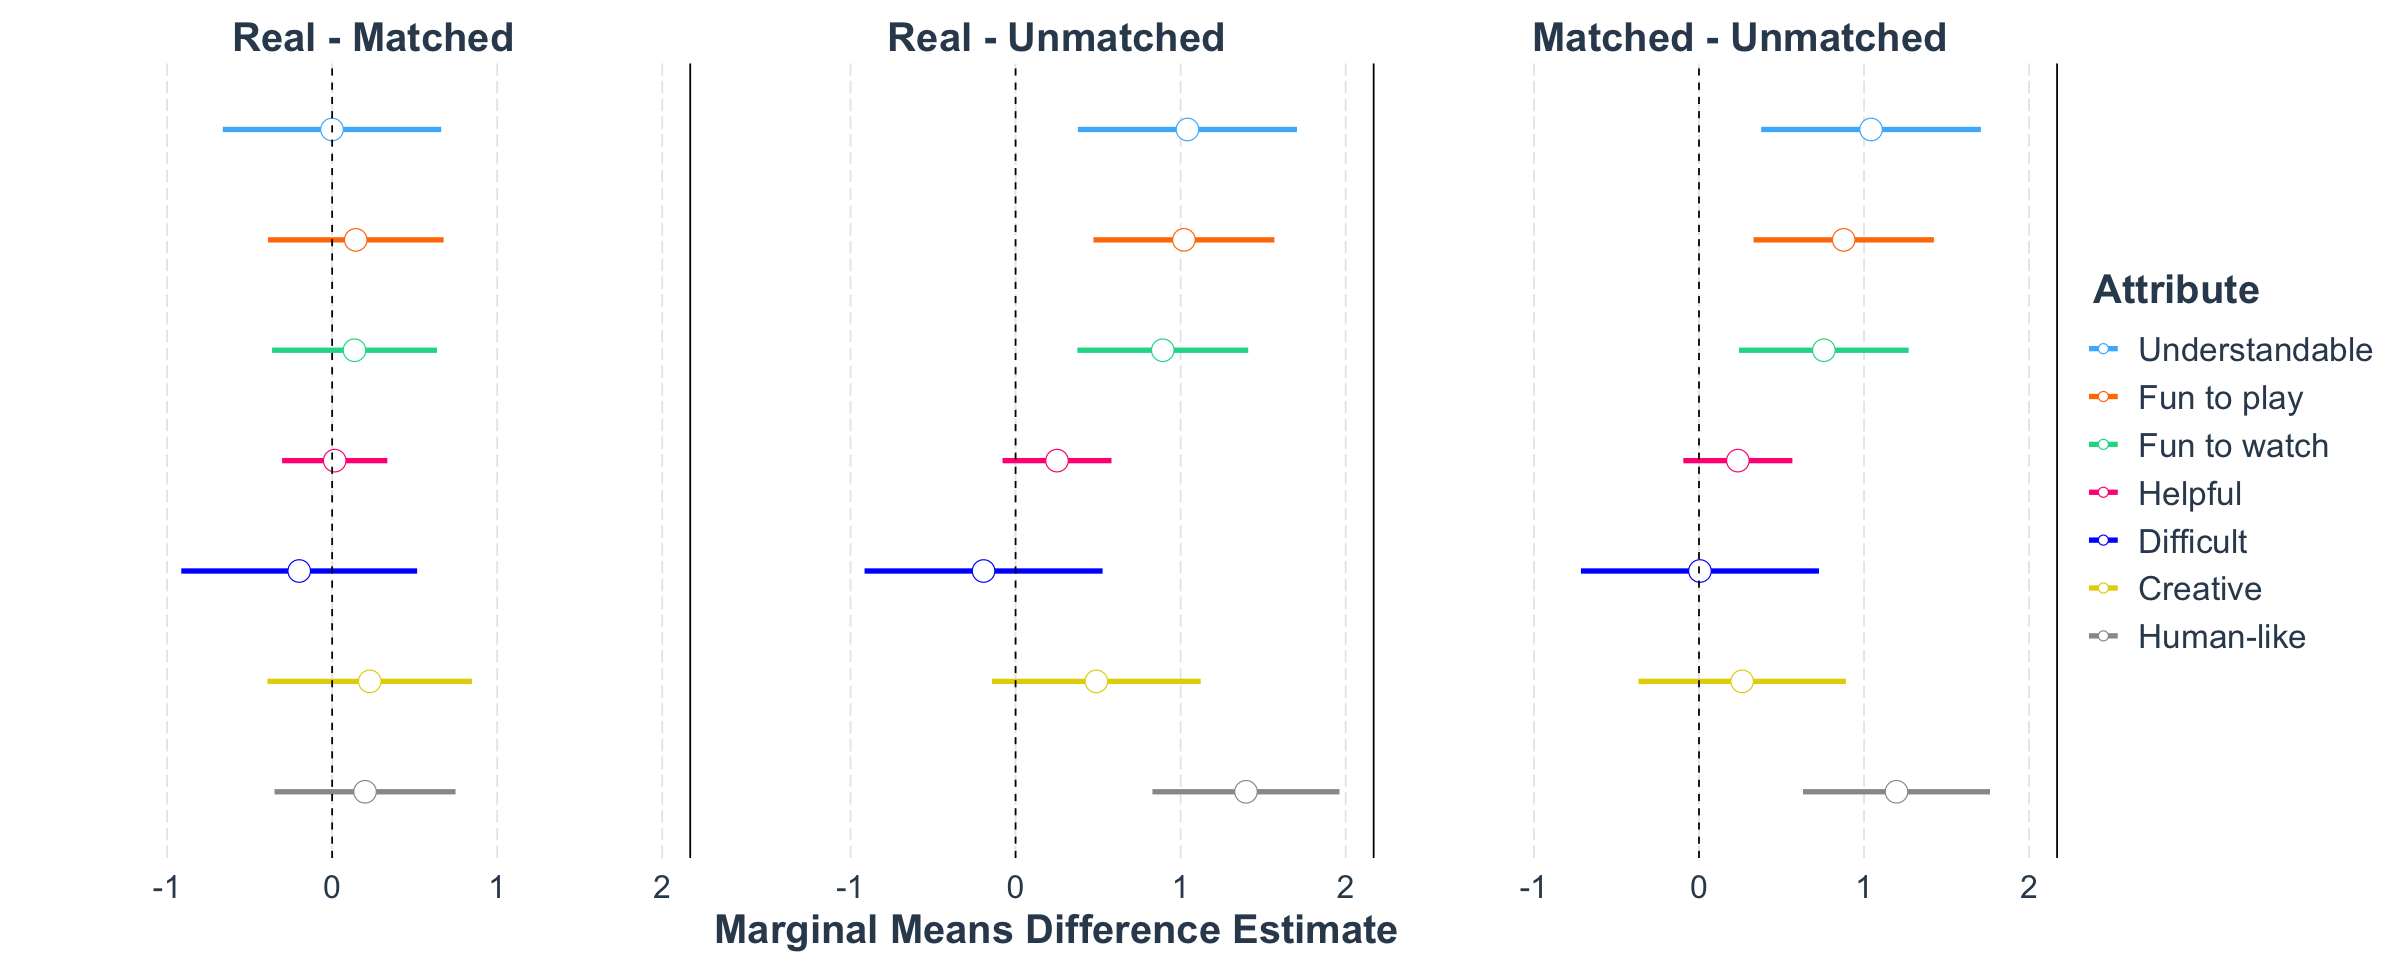

In [16]:
ggplot(game_type_only_summary_df, aes(x = estimate, y = attribute, color = contrast)) +
    geom_errorbarh(aes(xmin = estimate - SE2, xmax = estimate + SE2), height = 0, size = 1.5) +
    geom_point(size = 6, shape = 21, fill = "white") +
    aes(color = attribute) +
    scale_y_discrete(limits = rev) +
    scale_color_manual(values = get_colors(as.list("CUD Bright"), 7)) +
    facet_wrap(~contrast, nrow = 1, ncol = 3) +
    # scale_color_jtools(palette = "cud_bright") +
    labs(x = "Estimate", y = "Attribute") +
    theme_nice() +
    theme(
        text = element_text(size = 24, face = "bold"),
        legend.position = "right",
        legend.text = element_text(size = 20, face = "plain"),
        # legend.key.spacing.y = unit(0.4, "cm"),
        # legend.key.size = unit(1, "cm"),
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(face = "plain"),
        strip.text = element_text(size = 24, face = "bold"),
    ) +
    guides(color = guide_legend(title = "Attribute", override.aes = list(linetype = "solid", shape = 21, size = 2.5, linewidth = 1.5), byrow = TRUE)) +
    annotate(
        geom = "segment",
        x = Inf, xend = Inf,
        y = -Inf, yend = Inf,
        color = "black", , size = 1
    ) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
    xlim(-1.5, 2) +
    xlab("Marginal Means Difference Estimate") +
    ylab("") +
    theme(legend.spacing.y = unit(0.5, "cm"))

ggsave('./figures/game_type_only_model_marginal_means.pdf', dpi=900, width=20, height=6)


### Summary table without fitness scores

In [30]:
truncate_p_values <- FALSE
sig_figs <- 3

game_type_only_results_table <- data.frame(
    attribute = character(), 
    aic = numeric(),
    matched_est = numeric(),
    matched_z = numeric(),
    matched_p = numeric(),
    real_est = numeric(),
    real_z = numeric(),
    real_p = numeric()
)


for (name in names(game_type_only_model_list)) {
    model <- game_type_only_model_list[[name]]
    s <- summary(model)
    table_row <- data.frame(
        attribute = name,
        matched_est = glue("${formatC(s$coefficients[5, 1], digits = sig_figs, format = 'f')} \\pm {formatC(s$coefficients[5, 2], digits = sig_figs, format = 'f')}$"),
        matched_z = formatC(s$coefficients[5, 3], digits = sig_figs, format = 'f'),
        matched_p = s$coefficients[5, 4],
        real_est = glue("${formatC(s$coefficients[6, 1], digits = sig_figs, format = 'f')} \\pm {formatC(s$coefficients[6, 2], digits = sig_figs, format = 'f')}$"),
        real_z = formatC(s$coefficients[6, 3], digits = sig_figs, format = 'f'),
        real_p = s$coefficients[6, 4]
    )
    game_type_only_results_table <- rbind(game_type_only_results_table, table_row)
}



# Iterate through the columns
for (col in c("matched_p", "real_p")) {
    # Iterate through the cells
    for (i in seq_len(nrow(game_type_only_results_table))) {
        # Get the current value
        value <- as.double(game_type_only_results_table[i, col])
        # Modify the value based on the conditions
        if (truncate_p_values && value < 10^-5) {
            game_type_only_results_table[i, col] <- "$P < \\num{1e-5}^{ *** }$"
        } else if (truncate_p_values && value < 10^-3) {
            game_type_only_results_table[i, col] <- "$P < \\num{1e-3}^{ *** }$"
        } else {
            use_scientific <- value < 0.01
            v <- formatC(value, digits = sig_figs, format = ifelse(use_scientific, "e", "f"))
            if (use_scientific) {
                v <- glue("\\num{{{v}}}")
            }
            stars <- ifelse(value < 0.001, "***",
                ifelse(value < 0.01, "**", ifelse(value < 0.05, "*", ""))
            )
            if (stars != "") {
                game_type_only_results_table[i, col] <- glue("$P = {v}^{{ {stars} }}$")
            } else {
                game_type_only_results_table[i, col] <- glue("$P = {v}$")
            }
        }
    }
}


game_type_only_results_table

attribute,matched_est,matched_z,matched_p,real_est,real_z,real_p
<chr>,<glue>,<chr>,<chr>,<glue>,<chr>,<chr>
confident,$1.042 \pm 0.333$,3.133,$P = \num{1.731e-03}^{ ** }$,$1.042 \pm 0.332$,3.138,$P = \num{1.699e-03}^{ ** }$
fun_play,$0.877 \pm 0.273$,3.210,$P = \num{1.325e-03}^{ ** }$,$1.020 \pm 0.274$,3.722,$P = \num{1.976e-04}^{ *** }$
fun_watch,$0.757 \pm 0.257$,2.944,$P = \num{3.235e-03}^{ ** }$,$0.892 \pm 0.259$,3.446,$P = \num{5.693e-04}^{ *** }$
capability,$0.236 \pm 0.165$,1.426,$P = 0.154$,$0.251 \pm 0.165$,1.521,$P = 0.128$
goldilocks,$0.006 \pm 0.361$,0.016,$P = 0.987$,$-0.194 \pm 0.361$,-0.538,$P = 0.591$
creativity,$0.261 \pm 0.314$,0.832,$P = 0.405$,$0.489 \pm 0.316$,1.548,$P = 0.122$
human_likeness,$1.197 \pm 0.283$,4.225,$P = \num{2.388e-05}^{ *** }$,$1.396 \pm 0.283$,4.927,$P = \num{8.343e-07}^{ *** }$


In [31]:
# Convert the dataframe to an xtable object
game_type_only_results_table_latex <- xtable(game_type_only_results_table, digits = 3)

# Print the LaTeX table
print(game_type_only_results_table_latex, include.rownames = FALSE, floating = FALSE, sanitize.text.function = identity, digits=3)


% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Thu Aug 22 17:05:38 2024
\begin{tabular}{lllllll}
  \hline
attribute & matched_est & matched_z & matched_p & real_est & real_z & real_p \\ 
  \hline
confident & $1.042 \pm 0.333$ & 3.133 & $P = \num{1.731e-03}^{ ** }$ & $1.042 \pm 0.332$ & 3.138 & $P = \num{1.699e-03}^{ ** }$ \\ 
  fun_play & $0.877 \pm 0.273$ & 3.210 & $P = \num{1.325e-03}^{ ** }$ & $1.020 \pm 0.274$ & 3.722 & $P = \num{1.976e-04}^{ *** }$ \\ 
  fun_watch & $0.757 \pm 0.257$ & 2.944 & $P = \num{3.235e-03}^{ ** }$ & $0.892 \pm 0.259$ & 3.446 & $P = \num{5.693e-04}^{ *** }$ \\ 
  capability & $0.236 \pm 0.165$ & 1.426 & $P = 0.154$ & $0.251 \pm 0.165$ & 1.521 & $P = 0.128$ \\ 
  goldilocks & $0.006 \pm 0.361$ & 0.016 & $P = 0.987$ & $-0.194 \pm 0.361$ & -0.538 & $P = 0.591$ \\ 
  creativity & $0.261 \pm 0.314$ & 0.832 & $P = 0.405$ & $0.489 \pm 0.316$ & 1.548 & $P = 0.122$ \\ 
  human_likeness & $1.197 \pm 0.283$ & 4.225 & $P = \num{2.388e-05}^{ *** }$ & $1.39

### Marginal means without the fitness scores

In [15]:
truncate_p_values <- FALSE
sig_figs <- 3

game_type_only_mm_results_table <- data.frame(
    attribute = character(),
    r_m_est = numeric(),
    r_m_z = numeric(),
    r_m_p = numeric(),
    r_u_est = numeric(),
    r_u_z = numeric(),
    r_u_p = numeric(),
    m_u_est = numeric(),
    m_u_z = numeric(),
    m_u_p = numeric()
    
)


for (name in names(game_type_only_model_list)) {
    model <- game_type_only_model_list[[name]]
    em <- emmeans(model, "game_type")
    p <- pairs(em, reverse = TRUE)
    s <- summary(p)
    table_row <- data.frame(
        attribute = name,
        r_m_est = glue("${formatC(s[3, 2], digits = sig_figs, format = 'f')} \\pm {formatC(s[3, 3], digits = sig_figs, format = 'f')}$"),
        r_m_z = formatC(s[3, 5], digits = sig_figs, format = "f"),
        r_m_p = s[3, 6],
        r_u_est = glue("${formatC(s[2, 2], digits = sig_figs, format = 'f')} \\pm {formatC(s[2, 3], digits = sig_figs, format = 'f')}$"),
        r_u_z = formatC(s[2, 5], digits = sig_figs, format = "f"),
        r_u_p = s[2, 6],
        m_u_est = glue("${formatC(s[1, 2], digits = sig_figs, format = 'f')} \\pm {formatC(s[1, 3], digits = sig_figs, format = 'f')}$"),
        m_u_z = formatC(s[1, 5], digits = sig_figs, format = "f"),
        m_u_p = s[1, 6]
    )
    game_type_only_mm_results_table <- rbind(game_type_only_mm_results_table, table_row)
}


# Iterate through the columns
for (col in c("m_u_p", "r_u_p", "r_m_p")) {
    # Iterate through the cells
    for (i in seq_len(nrow(game_type_only_mm_results_table))) {
        # Get the current value
        value <- as.double(game_type_only_mm_results_table[i, col])

        # Modify the value based on the conditions
        if (truncate_p_values && value < 10^-5) {
            game_type_only_mm_results_table[i, col] <- "$P < \\num{1e-5}^{ *** }$"
        } else if (truncate_p_values && value < 10^-3) {
            game_type_only_mm_results_table[i, col] <- "$P < \\num{1e-3}^{ *** }$"
        } else {
            use_scientific <- value < 0.01
            v <- formatC(value, digits = sig_figs, format = ifelse(use_scientific, "e", "f"))
            if (use_scientific) {
                v <- glue("\\num{{{v}}}")
            }
            stars <- ifelse(value < 0.001, "***",
                ifelse(value < 0.01, "**", ifelse(value < 0.05, "*", ""))
            )
            if (stars != "") {
                game_type_only_mm_results_table[i, col] <- glue("$P = {v}^{{ {stars} }}$")
            } else {
                game_type_only_mm_results_table[i, col] <- glue("$P = {v}$")
            }
        }
    }
}

game_type_only_mm_results_table

Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"
Warning message:
"contrasts dropped from factor C(game_type)"


attribute,r_m_est,r_m_z,r_m_p,r_u_est,r_u_z,r_u_p,m_u_est,m_u_z,m_u_p
<chr>,<glue>,<chr>,<chr>,<glue>,<chr>,<chr>,<glue>,<chr>,<chr>
confident,$-0.001 \pm 0.331$,-0.003,$P = 1.000$,$1.042 \pm 0.332$,3.138,$P = \num{4.837e-03}^{ ** }$,$1.042 \pm 0.333$,3.133,$P = \num{4.927e-03}^{ ** }$
fun_play,$0.143 \pm 0.266$,0.538,$P = 0.853$,$1.020 \pm 0.274$,3.722,$P = \num{5.791e-04}^{ *** }$,$0.877 \pm 0.273$,3.210,$P = \num{3.791e-03}^{ ** }$
fun_watch,$0.135 \pm 0.250$,0.542,$P = 0.850$,$0.892 \pm 0.259$,3.446,$P = \num{1.650e-03}^{ ** }$,$0.757 \pm 0.257$,2.944,$P = \num{9.076e-03}^{ ** }$
capability,$0.016 \pm 0.159$,0.097,$P = 0.995$,$0.251 \pm 0.165$,1.521,$P = 0.281$,$0.236 \pm 0.165$,1.426,$P = 0.328$
goldilocks,$-0.200 \pm 0.357$,-0.559,$P = 0.842$,$-0.194 \pm 0.361$,-0.538,$P = 0.853$,$0.006 \pm 0.361$,0.016,$P = 1.000$
creativity,$0.228 \pm 0.310$,0.736,$P = 0.742$,$0.489 \pm 0.316$,1.548,$P = 0.269$,$0.261 \pm 0.314$,0.832,$P = 0.683$
human_likeness,$0.199 \pm 0.274$,0.727,$P = 0.748$,$1.396 \pm 0.283$,4.927,$P = \num{2.495e-06}^{ *** }$,$1.197 \pm 0.283$,4.225,$P = \num{7.088e-05}^{ *** }$


In [16]:
# Convert the dataframe to an xtable object
game_type_only_mm_results_table_latex <- xtable(game_type_only_mm_results_table, digits = 3)

# Print the LaTeX table
print(game_type_only_mm_results_table_latex, include.rownames = FALSE, floating = FALSE, sanitize.text.function = identity, digits=3)


% latex table generated in R 4.3.2 by xtable 1.8-4 package
% Thu Aug 22 17:00:47 2024
\begin{tabular}{llllllllll}
  \hline
attribute & r_m_est & r_m_z & r_m_p & r_u_est & r_u_z & r_u_p & m_u_est & m_u_z & m_u_p \\ 
  \hline
confident & $-0.001 \pm 0.331$ & -0.003 & $P = 1.000$ & $1.042 \pm 0.332$ & 3.138 & $P = \num{4.837e-03}^{ ** }$ & $1.042 \pm 0.333$ & 3.133 & $P = \num{4.927e-03}^{ ** }$ \\ 
  fun_play & $0.143 \pm 0.266$ & 0.538 & $P = 0.853$ & $1.020 \pm 0.274$ & 3.722 & $P = \num{5.791e-04}^{ *** }$ & $0.877 \pm 0.273$ & 3.210 & $P = \num{3.791e-03}^{ ** }$ \\ 
  fun_watch & $0.135 \pm 0.250$ & 0.542 & $P = 0.850$ & $0.892 \pm 0.259$ & 3.446 & $P = \num{1.650e-03}^{ ** }$ & $0.757 \pm 0.257$ & 2.944 & $P = \num{9.076e-03}^{ ** }$ \\ 
  capability & $0.016 \pm 0.159$ & 0.097 & $P = 0.995$ & $0.251 \pm 0.165$ & 1.521 & $P = 0.281$ & $0.236 \pm 0.165$ & 1.426 & $P = 0.328$ \\ 
  goldilocks & $-0.200 \pm 0.357$ & -0.559 & $P = 0.842$ & $-0.194 \pm 0.361$ & -0.538 & $P = 0.853$ & $0